# Text Vectorization

## Setup

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
try:
  import dill
except:
  !pip install dill
  import dill
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
try:
  from unidecode import unidecode
except:
  !pip install unidecode
  from unidecode import unidecode

pd.set_option('display.max_rows', None)  ###
pd.set_option('display.max_columns', None)  ###
pd.set_option('display.width', None)  ###
pd.set_option('display.max_colwidth', None)  ###

import warnings
warnings.filterwarnings('ignore')

import spacy
try:
    nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])
except:
    from spacy.cli import download

    download("en_core_web_sm")
    nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 2.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 2.6 MB/s eta 0:00:00


In [20]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:  
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)
  # connect your colab with the drive
  drive.mount(mount)

 # Switch to the directory on the Google Drive that you want to use
  import os
  path_to_repo = mount + "/MyDrive/MIMIC-III Text Mining/LOS_FINAL/"

else:
  # Setup Repository
  with open("repo_info.txt", "r") as repo_info:
      path_to_repo = repo_info.readline()

  
print(path_to_repo)

path_to_data = f"{path_to_repo}data/"
path_to_raw = f"{path_to_data}raw/"
path_to_processed = f"{path_to_data}processed/"
path_to_lda = f"{path_to_data}lda/"
path_to_icd = f"{path_to_data}icd_codes/"
path_to_models = f"{path_to_repo}models/"
path_to_results = f"{path_to_repo}results/"
path_to_tables = f"{path_to_repo}tables/"

os.makedirs(path_to_tables, exist_ok = True)

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/MIMIC-III Text Mining/LOS_FINAL/


In [3]:
# PARAMETERS

session_seed = 42 # set seed for our session
test_proportion = 0.2

MAX_FEATURES = 10000 # maximum number of features
min_df = 5 # minimum frequency
max_df = 0.8 # maximum frequency
N_GRAM = (1,2) # n_gram range

seed_tag = f'_{session_seed}'

random.seed(session_seed)

## Process the dataset

In [4]:
# import dataset
file = f'{path_to_processed}df_mixed_discharge.csv.gzip'
raw_df = pd.read_csv(file, compression = 'gzip', low_memory=False)

In [5]:
# examine the variables (names)
raw_df.columns

Index(['hadm_id', 'subject_id', 'ethnicity', 'admission_type',
       'admission_location', 'insurance', 'religion', 'marital_status',
       'icu_los', 'gender', 'age', 'urea_n_min', 'urea_n_max', 'urea_n_mean',
       'platelets_min', 'platelets_max', 'platelets_mean', 'magnesium_max',
       'albumin_min', 'calcium_min', 'resprate_min', 'resprate_max',
       'resprate_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'hr_min',
       'hr_max', 'hr_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean',
       'diasbp_min', 'diasbp_max', 'diasbp_mean', 'temp_min', 'temp_max',
       'temp_mean', 'sapsii', 'sofa', 'urine_min', 'urine_mean', 'urine_max',
       'patientweight', 'age_cat', 'type_stay', 'prev_adm', 'dest_discharge',
       'emergency_dpt', 'icd_chapter', 'origin_patient', 'los', 'text'],
      dtype='object')

In [6]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['hadm_id', 'subject_id','icu_los'])


In [7]:
df.shape

(30985, 50)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30985 entries, 0 to 30984
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ethnicity           30985 non-null  object 
 1   admission_type      30985 non-null  object 
 2   admission_location  30985 non-null  object 
 3   insurance           30985 non-null  object 
 4   religion            30985 non-null  object 
 5   marital_status      30985 non-null  object 
 6   gender              30985 non-null  object 
 7   age                 30985 non-null  float64
 8   urea_n_min          30976 non-null  float64
 9   urea_n_max          30976 non-null  float64
 10  urea_n_mean         30976 non-null  float64
 11  platelets_min       30974 non-null  float64
 12  platelets_max       30974 non-null  float64
 13  platelets_mean      30974 non-null  float64
 14  magnesium_max       30890 non-null  float64
 15  albumin_min         20330 non-null  float64
 16  calc

In [9]:
# Transform the LOS timedelta to days (as decimal values to increase precision)
df['los'] = pd.to_timedelta(df.los)
df['los'] = df.los/pd.to_timedelta(1, unit='D')

In [10]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(30985, 30764)

In [17]:
# check proportion of missing values
missing = pd.concat([df.isna().sum(), df.isna().mean()], axis = 1)
missing.columns = ['count', 'proportions']
missing.sort_values('proportions',ascending = False)

,count,proportions
patientweight,14847,0.482610
albumin_min,10503,0.341406
calcium_min,819,0.026622
glucose_mean,64,0.002080
glucose_max,64,0.002080
glucose_min,64,0.002080
magnesium_max,64,0.002080
temp_mean,45,0.001463
temp_max,45,0.001463
temp_min,45,0.001463


In [23]:
# Save it as a table
missing.sort_values('proportions',ascending = False).to_excel(f"{path_to_tables}missing_table.xlsx")

In [18]:
# drop variables having more than 20 % missing values
print(f"Variables with more than 20% Missing Values: {list(missing.loc[missing.proportions >= 0.2].index)}")
df = df.drop(columns=missing.loc[missing.proportions >= 0.2].index)

Variables with more than 20% Missing Values: ['albumin_min', 'patientweight']


In [ ]:
# impute missing values
df = df.interpolate()
df.isna().mean()

ethnicity             0.0
admission_type        0.0
admission_location    0.0
insurance             0.0
religion              0.0
marital_status        0.0
gender                0.0
age                   0.0
urea_n_min            0.0
urea_n_max            0.0
urea_n_mean           0.0
platelets_min         0.0
platelets_max         0.0
platelets_mean        0.0
magnesium_max         0.0
calcium_min           0.0
resprate_min          0.0
resprate_max          0.0
resprate_mean         0.0
glucose_min           0.0
glucose_max           0.0
glucose_mean          0.0
hr_min                0.0
hr_max                0.0
hr_mean               0.0
sysbp_min             0.0
sysbp_max             0.0
sysbp_mean            0.0
diasbp_min            0.0
diasbp_max            0.0
diasbp_mean           0.0
temp_min              0.0
temp_max              0.0
temp_mean             0.0
sapsii                0.0
sofa                  0.0
urine_min             0.0
urine_mean            0.0
urine_max   

## Binarize LOS

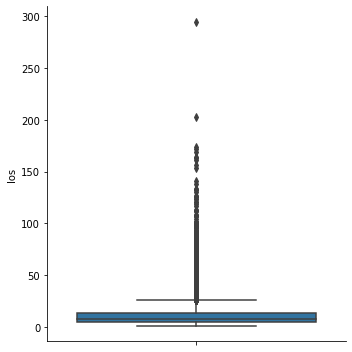

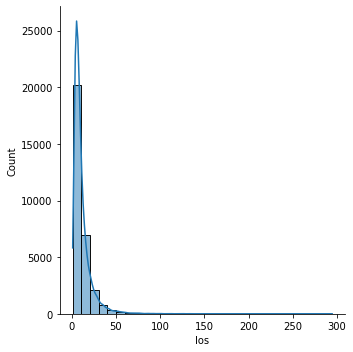

In [ ]:
# check distribution of outcome
sns.catplot(kind='box', data=df, y='los');
sns.displot(data=df, x="los", bins=30, kde=True) ;

In [ ]:
# compute Lower and Upper Fence according to Tukey's criteria
y = df['los']
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3-Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR
print(f'First quartile = {Q1:.3f}, Third Quartile = {Q3:.3f}, Interquartile Interval = {IQR:.3f}')
print(f'Lower Fence = {LF:.3f}, Upper Fence = {UF:.3f}')

First quartile = 5.051, Third Quartile = 13.388, Interquartile Interval = 8.338
Lower Fence = -7.456, Upper Fence = 25.895


In [ ]:
# create categorical LOS variable where prolonged LOS is any value greater than Upper Fence
df['los_cat'] = df['los']> UF
df = df.drop(columns=['los'])

In [ ]:
df['los_cat'].value_counts()

False    28525
True      2239
Name: los_cat, dtype: int64

In [ ]:
df['los_cat'].value_counts(normalize=True)

False    0.92722
True     0.07278
Name: los_cat, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30764 entries, 0 to 30984
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ethnicity           30764 non-null  object 
 1   admission_type      30764 non-null  object 
 2   admission_location  30764 non-null  object 
 3   insurance           30764 non-null  object 
 4   religion            30764 non-null  object 
 5   marital_status      30764 non-null  object 
 6   gender              30764 non-null  object 
 7   age                 30764 non-null  float64
 8   urea_n_min          30764 non-null  float64
 9   urea_n_max          30764 non-null  float64
 10  urea_n_mean         30764 non-null  float64
 11  platelets_min       30764 non-null  float64
 12  platelets_max       30764 non-null  float64
 13  platelets_mean      30764 non-null  float64
 14  magnesium_max       30764 non-null  float64
 15  calcium_min         30764 non-null  float64
 16  resp

## Heavier Preprocessing & BoW - Define Functions

In [ ]:
stemmer = SnowballStemmer("english", ignore_stopwords=True) # we initialize our stemmer
stop_words = stopwords.words('english') # nltk stopwords
lemmatizer = WordNetLemmatizer() # lemmatizer in case we want to lemmatize instead of stemming

In [ ]:
def remove_stopwords(text):
    text =  " ".join([x for x in text.split()if x not in stop_words]) # delete stopwords from text
    return text

def heading_clean(text):
  text = re.sub(r'\[\*\*(.+?)\*\*\]', "", text) # we take out information in brackets
  text = re.sub(r'(Admission Date:)|(Discharge Date:)|(Date of Birth:)|(Name:)|(Unit No:)', "", text, flags = re.I)
  if preproc_heavier:
    text = re.sub(r'Sex:', "", text, flags = re.I)
    text = text.lower() # lowercase text
    text = unidecode((text))
    text = re.sub(r'[^\w\s]','',text)
    if lemmatize == True:
        if use_spacy == True:
            doc = nlp(text)
            text = " ".join([token.lemma_ for token in doc])
        else:
            text =  " ".join([lemmatizer.lemmatize(x) for x in text.split()])
    else:
        text =  " ".join([stemmer.stem(x) for x in text.split()])
    text = remove_stopwords(text)
  return text

In [ ]:
def vectorize_to_dataframe(df, vectorizer_obj):
    """
    Function to return a dataframe from our vectorizer results
    """
    df = pd.DataFrame(data = df.toarray(), columns = vectorizer_obj.get_feature_names())
    return df

In [ ]:
def vectorize_features(X_train, X_test, method = 'frequency'):
    """
    Function to perform vectorization of our test sets
    X_train, X_test, X_val: our dataframes
    method: either 'frequency', 'tf_idf', 'onehot' to employ a different BoW technique
    """
    # initialize our vectorizer
    if method == 'tf_idf':
        vectorizer = TfidfVectorizer(ngram_range=N_GRAM, min_df=min_df, max_df=max_df, max_features=MAX_FEATURES)
    elif method == 'frequency':
        vectorizer = CountVectorizer(ngram_range=N_GRAM, min_df=min_df, max_df=max_df, max_features=MAX_FEATURES)
    elif method == 'onehot':
        vectorizer = CountVectorizer(ngram_range=N_GRAM, min_df=min_df, max_df=max_df, max_features=MAX_FEATURES, binary = True)
        
    train_text = vectorizer.fit_transform(X_train.text)
    train_text = vectorize_to_dataframe(train_text, vectorizer)
    test_text = vectorizer.transform(X_test.text)
    test_text = vectorize_to_dataframe(test_text, vectorizer)
    return train_text, test_text

In [ ]:
def save_dataframes(train, test, method, target = False):
    """
    Function to save our dataframes
    train: train set to be saved
    method: method through which we have processed the dataframes, needed as save keyword
    test: test set to be saved
    """
    # need to reset the index
    train.reset_index(inplace=True, drop = True)
    # save our dataset up to now in feather format
    train.to_feather('{}{}train_{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag))
    # need to reset the index
    test.reset_index(inplace=True, drop = True)
    # save our dataset up to now in feather format
    test.to_feather('{}{}test_{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag))

In [ ]:
def load_datasets(method):
    """
    Function to load train, test and validation set based on the chosen method
    method: string for the processing method we want to load
    """
    global path_to_processed
    # load it back
    train = pd.read_feather('{}{}train_{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag))
    test = pd.read_feather('{}{}test_{}{}{}'.format(path_to_processed, method, seed_tag, preproc_tag, lemma_tag))
    return train, test

### Vectorization Loop

In [ ]:
# Iterate over our main methods of vectorization

vect_dict = {'stemming': (False, False),
             'spacy': (True, True)}

             
for key, value in vect_dict.items():
    print(key)
    # PARAMETERS

    lemmatize = value[0] # set to false if we want to do stemming
    lemma_tag = str(np.where(lemmatize, "_lemma",""))
    use_spacy = value[1]
    if use_spacy: lemma_tag = str(np.where(lemmatize, "_lemma_spacy",""))

    preprocessing = True # set to true if we want to clean and perform some preprocessing
    preproc_heavier = True # set to True if we want a heavier preprocessing
    preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
    preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')
  
    if preprocessing:
        try:
            df = pd.read_feather(f'{path_to_processed}df_los{preproc_tag}{lemma_tag}')
            print('Dataframe Loaded')
        except:
            df['text'] = df.text.apply(lambda x: heading_clean(x))
            # need to reset the index
            df.reset_index(inplace=True, drop = True)
            # save our dataset up to now in feather format
            df.to_feather(f'{path_to_processed}df_los{preproc_tag}{lemma_tag}')
            print('Dataframe Saved')
        # split the data into training and test
        train, test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)
    # perform vectorization
    method_list = ['frequency', 'onehot','tf_idf']
    train_clean = train.drop(columns = 'text')
    train_clean.reset_index(inplace = True, drop = True)
    test_clean = test.drop(columns = 'text')
    test_clean.reset_index(inplace = True, drop = True)
    for method in method_list:
        print(method)
        # for each method we perform vectorization
        train_text, test_text = vectorize_features(train, test, method = method)
        # Drop the text column and concatenate it
        X_train = pd.concat([train_clean, train_text], axis = 1)
        X_test = pd.concat([test_clean, test_text], axis = 1)
        assert X_train.shape[0] == train_clean.shape[0]
        assert X_test.shape[0] == test_clean.shape[0]
        # and save the dataframes
        save_dataframes(X_train, X_test, method = method)
        # And also perform LDA
        try:
            with open(f'{path_to_lda}lda{seed_tag}{method}{preproc_tag}{lemma_tag}', 'rb') as file: # and save the fitted model
                lda = dill.load(file)
            train_lda = lda.transform(train_text)
        except:
            lda = LatentDirichletAllocation(n_components = 300, random_state = session_seed, n_jobs = -1)
            train_lda = lda.fit_transform(train_text)
        train_lda = pd.DataFrame(train_lda)
        train_lda.columns=["F"+str(i) for i in range(0, len(train_lda.columns))]
        test_lda = lda.transform(test_text)
        test_lda = pd.DataFrame(test_lda)
        test_lda.columns=["F"+str(i) for i in range(0, len(test_lda.columns))]
        # Drop the text column and concatenate it
        X_train = pd.concat([train_clean, train_lda], axis = 1)
        X_test = pd.concat([test_clean, test_lda], axis = 1)
        assert X_train.shape[0] == train_clean.shape[0]
        assert X_test.shape[0] == test_clean.shape[0]
        save_dataframes(X_train, X_test, method = f'lda_{method}')
        with open(f'{path_to_lda}lda{seed_tag}{method}{preproc_tag}{lemma_tag}', 'wb') as file: # and save the fitted model
            dill.dump(lda, file)

## Save Topic-Words combination

In [ ]:
# We now want to export for each LDA model the corresponding words in an excel file

vect_dict = {'stemming': (False, False),
             'spacy': (True, True)}
    
for key, value in vect_dict.items():
    print(key)
    # PARAMETERS

    lemmatize = value[0] # set to false if we want to do stemming
    lemma_tag = str(np.where(lemmatize, "_lemma",""))
    use_spacy = value[1]
    if use_spacy: lemma_tag = str(np.where(lemmatize, "_lemma_spacy",""))

    preprocessing = True # set to true if we want to clean and perform some preprocessing
    preproc_heavier = True # set to True if we want a heavier preprocessing
    preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
    preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')

    # List of BoW methods
    method_list = ['frequency', 'tf_idf', 'onehot']

    # Initialize an excel writer where we are going to save all the various word-topic for each method
    writer = pd.ExcelWriter(f'{path_to_lda}\output_lda_{key}.xlsx')

    # Iterate over all 3 methods
    for method in method_list:

        # Re-Load our LDA model
        with open(f'{path_to_lda}lda{seed_tag}{method}{preproc_tag}{lemma_tag}', 'rb') as file: # and save the fitted model
            lda = dill.load(file)

        # Load the datasets constructed with the BOW method
        _, test = load_datasets(method)

        # Get the words - and remove the placeholder "dischargetext_"
        text_col = [re.sub("dischargetext_", "",col) for col in test.columns if "dischargetext" in col]


        # Create a pandas dataframe out of the LDA components
        lda_components = pd.DataFrame(lda.components_, columns = text_col, index = [f"F{i}" for i in range(0, 300)]).T

        # Create a sheet for our current method
        workbook=writer.book
        worksheet=workbook.add_worksheet(f'{method}')
        writer.sheets[f'{method}'] = worksheet

        lda_components.to_excel(writer,sheet_name=f'{method}')
    # Close the excel workbook   
    writer.close()